In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as pl

d:\Program Files\anaconda3\envs\torch126\Lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
import sys
sys.path.append("D:\\0626_temp")

from flare_preprocessing import *
from utilities import *

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
opr = opr_data_preprocessing("D:/2024_S1/ML_SEP_2402/swpc_ftp/v2_ftp_flares_1997_2024.csv")
sci = sci_data_preprocessing("D:/2024_S1/ML_SEP_2402/Sci_matched_with_assigned_ar_20100101_20240721.csv", opr)

Shape of the operation data: (25364, 9)
Shape of the science-quality data: (30958, 31)


D:\0626_temp\utilities.py:64: RuntimeWarning: divide by zero encountered in log10
  return np.log10(intensity * 10 ** -8)


## nrt SHARP

In [7]:
from pathlib import Path

def read_all_harp_csvs(root: str | Path, recursive: bool = False) -> pd.DataFrame:
    """
    Read all per-HARP CSVs under `root`, concatenate them in ascending HARP order,
    Assumes files are named like HARP_<harpnum>.csv.
    """

    root = Path(root)
    pattern = "**/HARP_*.csv" if recursive else "HARP_*.csv"

    # List files first, sorted by HARP number
    harp_files = []
    for f in root.glob(pattern):
        try:
            harpnum = int(f.stem.split("_")[1])
            harp_files.append((harpnum, f))
        except Exception:
            continue

    # sort by numeric harp number
    harp_files.sort(key=lambda x: x[0])

    frames = []

    for harpnum, f in harp_files:
        # read with T_REC parsed as datetime
        df = pd.read_csv(f, parse_dates=["T_REC"])
        print(f"Reading HARP {harpnum}")

        # Skip if the HARP lifetime is less than 120 rows (24h / 12min cadence)
        if len(df) < 120:
            print(f"  -> Skipping HARP {harpnum} (too short)")
            continue
        # fill the HARPNUM with the harpnum
        df['HARPNUM'] = harpnum
        frames.append(df)

    if not frames:
        print("No valid HARP CSVs found.")
        return pd.DataFrame()

    # Concatenate in correct order
    full_df = pd.concat(frames, ignore_index=True)
    print(f"Loaded {len(frames)} HARPs; total rows = {len(full_df)}")
    
    return full_df

In [8]:
nrt_sharps = read_all_harp_csvs(r"D:\\Input Data\\Operational Data\\HMI\SHARP_by_HARP")

Reading HARP 476
Reading HARP 487
Reading HARP 493
Reading HARP 495
Reading HARP 497
Reading HARP 498
Reading HARP 499
  -> Skipping HARP 499 (too short)
Reading HARP 500
  -> Skipping HARP 500 (too short)
Reading HARP 501
Reading HARP 502
Reading HARP 503
Reading HARP 504
Reading HARP 505
Reading HARP 506
  -> Skipping HARP 506 (too short)
Reading HARP 508
Reading HARP 509
Reading HARP 510
Reading HARP 511
Reading HARP 512
Reading HARP 513
  -> Skipping HARP 513 (too short)
Reading HARP 514
  -> Skipping HARP 514 (too short)
Reading HARP 515
Reading HARP 516
Reading HARP 518
  -> Skipping HARP 518 (too short)
Reading HARP 520
Reading HARP 521
Reading HARP 523
Reading HARP 524
  -> Skipping HARP 524 (too short)
Reading HARP 526
Reading HARP 527
Reading HARP 529
Reading HARP 532
Reading HARP 533
  -> Skipping HARP 533 (too short)
Reading HARP 534
Reading HARP 537
Reading HARP 547
  -> Skipping HARP 547 (too short)
Reading HARP 550
Reading HARP 552
  -> Skipping HARP 552 (too short)
Read

C:\Users\huke0\AppData\Local\Temp\ipykernel_20092\2427577827.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, parse_dates=["T_REC"])


Reading HARP 11106
  -> Skipping HARP 11106 (too short)
Reading HARP 11107
  -> Skipping HARP 11107 (too short)
Reading HARP 11108
  -> Skipping HARP 11108 (too short)
Reading HARP 11123
  -> Skipping HARP 11123 (too short)
Reading HARP 11172
Reading HARP 11174
Reading HARP 11197
Reading HARP 11199
Reading HARP 11200
Reading HARP 11203
Reading HARP 11207
  -> Skipping HARP 11207 (too short)
Reading HARP 11209
Reading HARP 11210
Reading HARP 11211
  -> Skipping HARP 11211 (too short)
Reading HARP 11212
  -> Skipping HARP 11212 (too short)
Reading HARP 11215
Reading HARP 11217
Reading HARP 11218
Reading HARP 11219
Reading HARP 11220
  -> Skipping HARP 11220 (too short)
Reading HARP 11221
Reading HARP 11222
Reading HARP 11223
  -> Skipping HARP 11223 (too short)
Reading HARP 11224
  -> Skipping HARP 11224 (too short)
Reading HARP 11225
Reading HARP 11226
  -> Skipping HARP 11226 (too short)
Reading HARP 11227
  -> Skipping HARP 11227 (too short)
Reading HARP 11229
  -> Skipping HARP 11229

In [9]:
# delete rows with key columns any NaN values
key_columns = [
    'USFLUX','MEANGAM','MEANGBT','MEANGBZ','MEANGBH','MEANJZD',
    'TOTUSJZ','MEANALP','MEANJZH','TOTUSJH','ABSNJZH','SAVNCPP',
    'MEANPOT','TOTPOT','MEANSHR','SHRGT45','SIZE','SIZE_ACR',
    'NACR','NPIX'
]
nrt_sharps = nrt_sharps.dropna(subset=key_columns)

In [14]:
sci_NRT_nowcasting_obj_24 = New_SampleConstruction()
sci_NRT_nowcasting_obj_24.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=24)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [15]:
sci_NRT_nowcasting_obj_12 = New_SampleConstruction()
sci_NRT_nowcasting_obj_12.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=12)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [16]:
sci_NRT_nowcasting_obj_6 = New_SampleConstruction()
sci_NRT_nowcasting_obj_6.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=6)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [5]:
from New_logistic import *

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.35000000000000003 - 0.55
The 95% CI for TSS is 0.6050408520571929 - 0.7376130726583017


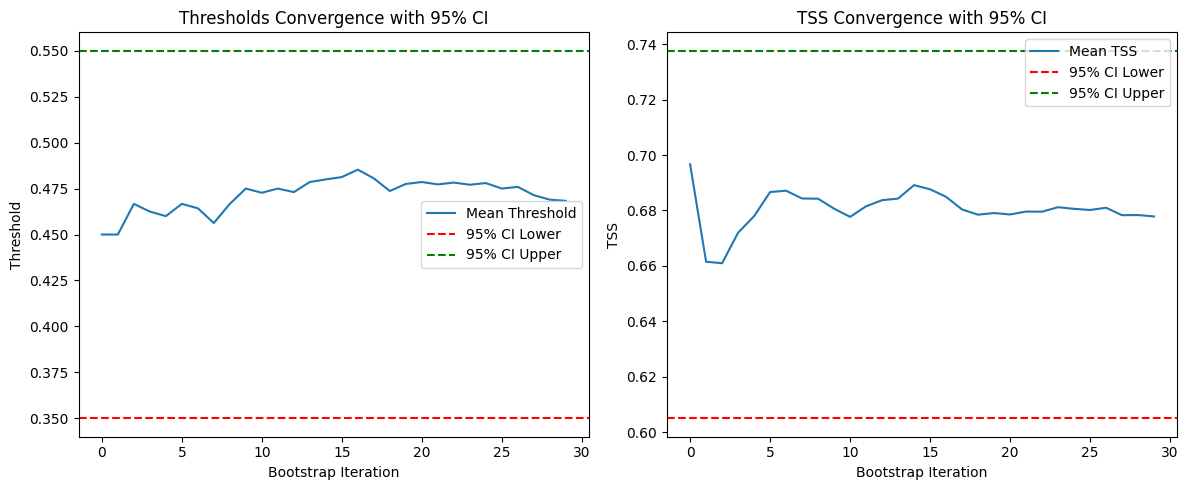

In [18]:
sci_nrt_24 = train_logistic(n_booststrap=30)
sci_nrt_24.train_logistic(sci_NRT_nowcasting_obj_24.inputs_profile, sci_NRT_nowcasting_obj_24.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'))

In [19]:
save_dir_sci_nrt = ".\\Logreg_models\\Sci_nrtSHARP"

In [6]:
import joblib

In [23]:
for i, model in enumerate(sci_nrt_24.models):
    os.makedirs(save_dir_sci_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_sci_nrt, f"logistic_sci_nrtSHARP_24_{i}.pth")
    joblib.dump(model, model_path)

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.30000000000000004 - 0.55
The 95% CI for TSS is 0.6363229442970822 - 0.7646883289124669


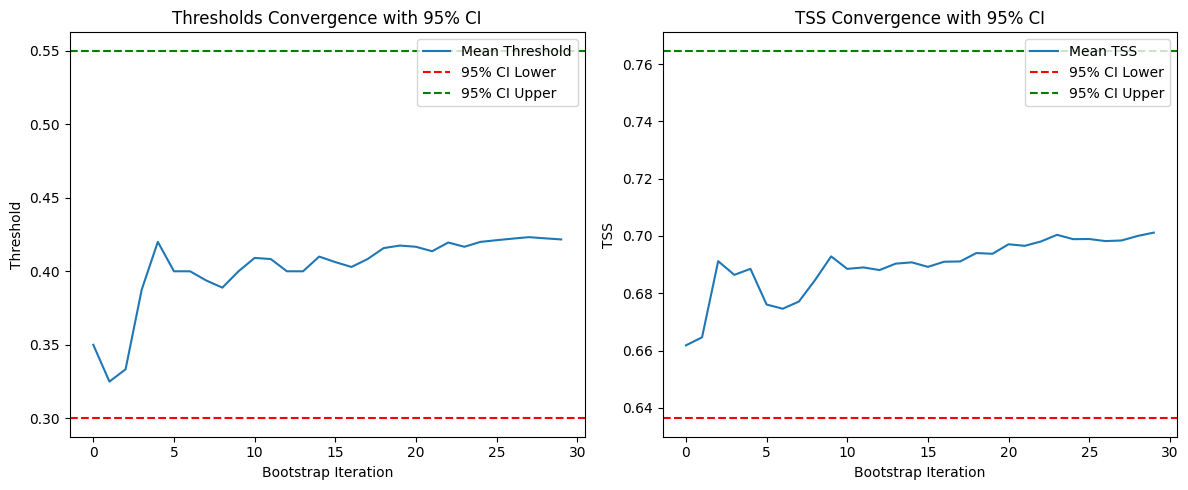

In [24]:
sci_nrt_12 = train_logistic(n_booststrap=30)
sci_nrt_12.train_logistic(sci_NRT_nowcasting_obj_12.inputs_profile, sci_NRT_nowcasting_obj_12.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'))

In [25]:
for i, model in enumerate(sci_nrt_12.models):
    os.makedirs(save_dir_sci_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_sci_nrt, f"logistic_sci_nrtSHARP_12{i}.pth")
    joblib.dump(model, model_path)

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.2 - 0.71375
The 95% CI for TSS is 0.3711344537815126 - 0.6306302521008403


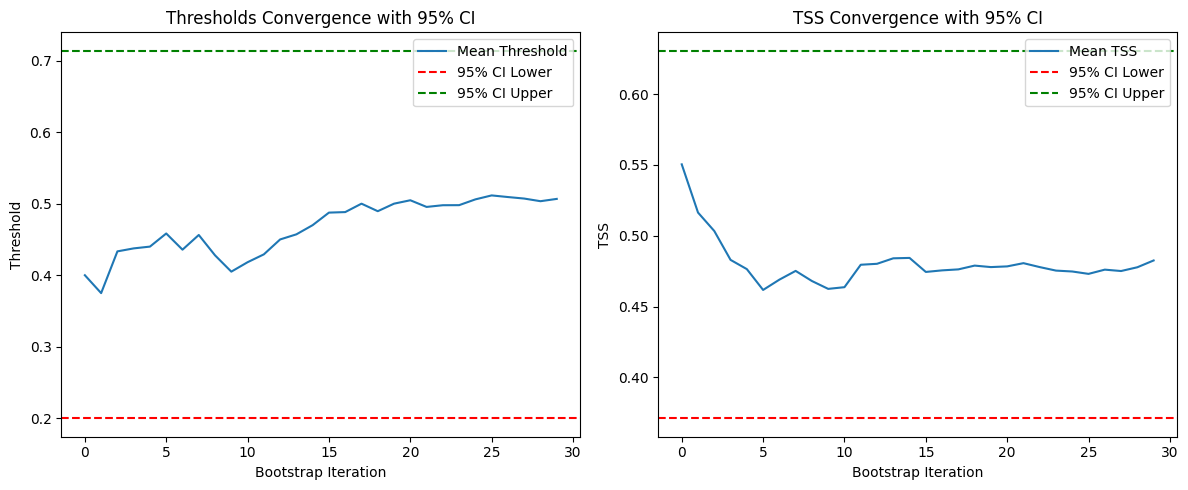

In [26]:
sci_nrt_6 = train_logistic(n_booststrap=30)
sci_nrt_6.train_logistic(sci_NRT_nowcasting_obj_6.inputs_profile, sci_NRT_nowcasting_obj_6.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'))

In [27]:
for i, model in enumerate(sci_nrt_6.models):
    os.makedirs(save_dir_sci_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_sci_nrt, f"logistic_sci_nrtSHARP_6_{i}.pth")
    joblib.dump(model, model_path)

In [28]:
opr_NRT_nowcasting_obj_24 = New_SampleConstruction()
opr_NRT_nowcasting_obj_24.samples_from_harp(opr, nrt_sharps, lead_window=0, forecasting_window=24)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [29]:
opr_NRT_nowcasting_obj_12 = New_SampleConstruction()
opr_NRT_nowcasting_obj_12.samples_from_harp(opr, nrt_sharps, lead_window=0, forecasting_window=12)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [30]:
opr_NRT_nowcasting_obj_6 = New_SampleConstruction()
opr_NRT_nowcasting_obj_6.samples_from_harp(opr, nrt_sharps, lead_window=0, forecasting_window=6)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.35000000000000003 - 0.65
The 95% CI for TSS is 0.5032246138678935 - 0.6650221820571803


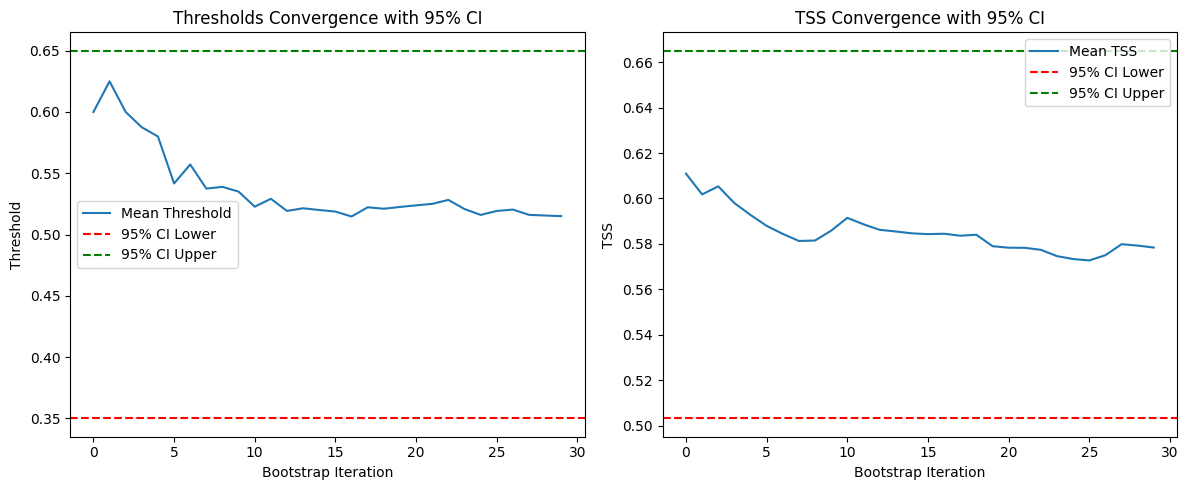

In [31]:
opr_nrt_24 = train_logistic(n_booststrap=30)
opr_nrt_24.train_logistic(opr_NRT_nowcasting_obj_24.inputs_profile, opr_NRT_nowcasting_obj_24.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'))

In [32]:
save_dir_opr_nrt = ".\\Logreg_models\\Opr_nrtSHARP"

In [33]:
for i, model in enumerate(opr_nrt_24.models):
    os.makedirs(save_dir_opr_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_opr_nrt, f"logistic_opr_nrtSHARP_24_{i}.pth")
    joblib.dump(model, model_path)

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.42250000000000004 - 0.6000000000000001
The 95% CI for TSS is 0.49987468671679197 - 0.7023182957393483


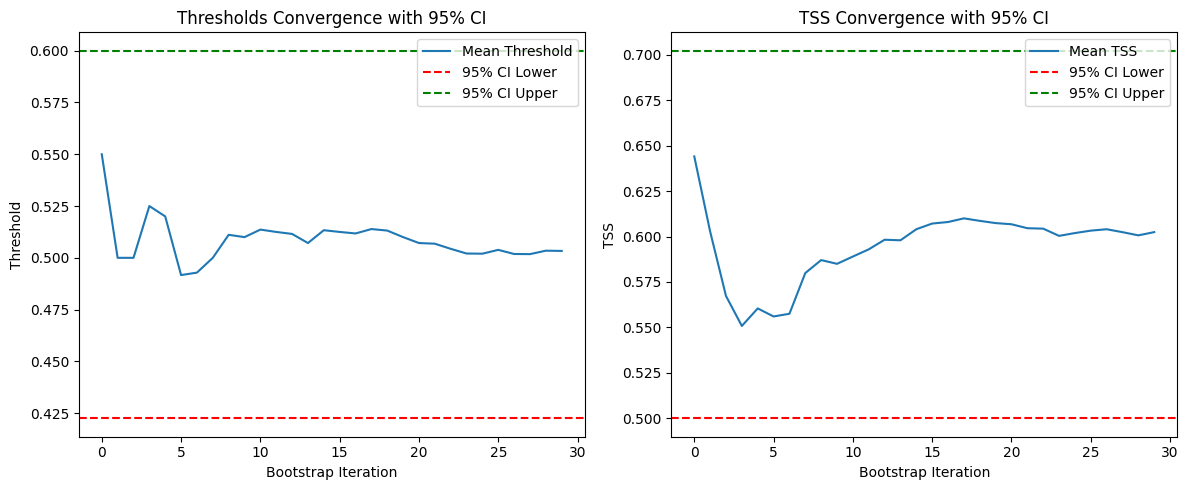

In [34]:
opr_nrt_12 = train_logistic(n_booststrap=30)
opr_nrt_12.train_logistic(opr_NRT_nowcasting_obj_12.inputs_profile, opr_NRT_nowcasting_obj_12.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'))

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.35000000000000003 - 0.8500000000000001
The 95% CI for TSS is 0.4347863247863248 - 0.5873076923076922


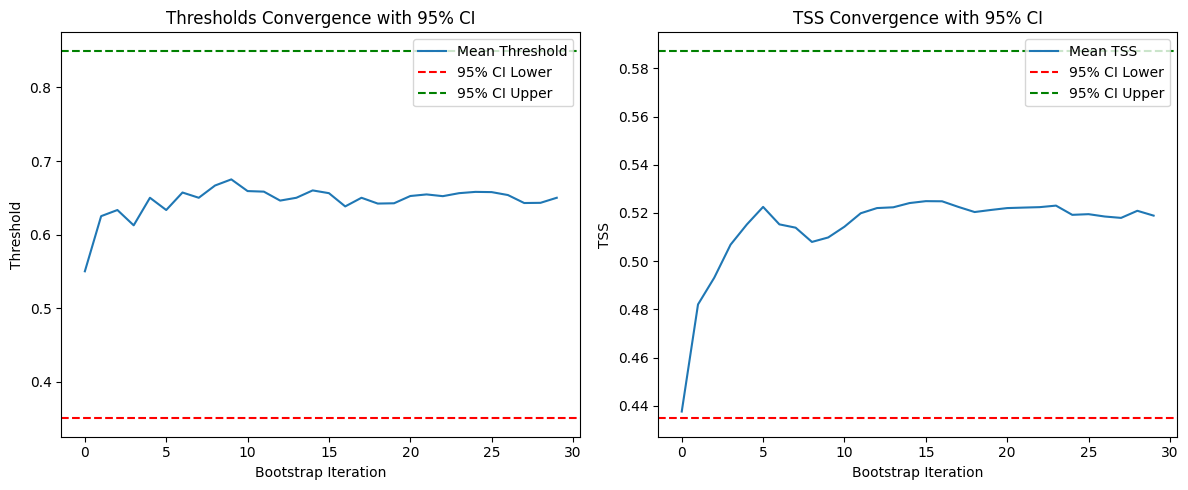

In [35]:
opr_nrt_6 = train_logistic(n_booststrap=30)
opr_nrt_6.train_logistic(opr_NRT_nowcasting_obj_6.inputs_profile, opr_NRT_nowcasting_obj_6.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'))

In [36]:
for i, model in enumerate(opr_nrt_12.models):
    os.makedirs(save_dir_opr_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_opr_nrt, f"logistic_opr_nrtSHARP_12_{i}.pth")
    joblib.dump(model, model_path)

In [37]:
for i, model in enumerate(opr_nrt_6.models):
    os.makedirs(save_dir_opr_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_opr_nrt, f"logistic_opr_nrtSHARP_6_{i}.pth")
    joblib.dump(model, model_path)

## Definitive SHARP

In [7]:
# read the parquet file
import fastparquet
high_qual_sharp = pd.read_parquet('D:\\0626_temp\\processed_high-qual_near-center-70_no-nas_flares.parquet', engine='fastparquet')

In [8]:
from New_SampleConstruction import *

In [39]:
sci_def_obj_24 = New_SampleConstruction()
sci_def_obj_24.samples_from_harp(sci, high_qual_sharp, lead_window=0, forecasting_window=24)

Processing HARPNUM: 1
Processing HARPNUM: 2
Processing HARPNUM: 5
Processing HARPNUM: 6
Processing HARPNUM: 8
Processing HARPNUM: 10
Processing HARPNUM: 11
Processing HARPNUM: 12
Processing HARPNUM: 14
Processing HARPNUM: 15
Processing HARPNUM: 16
Processing HARPNUM: 17
Processing HARPNUM: 19
Processing HARPNUM: 20
Processing HARPNUM: 23
Processing HARPNUM: 24
Processing HARPNUM: 25
Processing HARPNUM: 26
Processing HARPNUM: 29
Processing HARPNUM: 32
Processing HARPNUM: 35
Processing HARPNUM: 36
Processing HARPNUM: 37
Processing HARPNUM: 38
Processing HARPNUM: 39
Processing HARPNUM: 40
Processing HARPNUM: 41
Processing HARPNUM: 43
Processing HARPNUM: 44
Processing HARPNUM: 45
Processing HARPNUM: 46
Processing HARPNUM: 47
Processing HARPNUM: 49
Processing HARPNUM: 50
Processing HARPNUM: 51
Processing HARPNUM: 53
Processing HARPNUM: 54
Processing HARPNUM: 57
Processing HARPNUM: 58
Processing HARPNUM: 59
Processing HARPNUM: 62
Processing HARPNUM: 66
Processing HARPNUM: 67
Processing HARPN

D:\0626_temp\New_SampleConstruction.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oneharp['T_REC'] = pd.to_datetime(oneharp['T_REC'])


Processing HARPNUM: 10876
Processing HARPNUM: 10879
Processing HARPNUM: 10880
Processing HARPNUM: 10882
Processing HARPNUM: 10884
Processing HARPNUM: 10885
Processing HARPNUM: 10889
Processing HARPNUM: 10894
Processing HARPNUM: 10895
Processing HARPNUM: 10897
Processing HARPNUM: 10899
Processing HARPNUM: 10900
Processing HARPNUM: 10902
Processing HARPNUM: 10903
Processing HARPNUM: 10907
Processing HARPNUM: 10911
Processing HARPNUM: 10913
Processing HARPNUM: 10915
Processing HARPNUM: 10921
Processing HARPNUM: 10922
Processing HARPNUM: 10923
Processing HARPNUM: 10924
Processing HARPNUM: 10927
Processing HARPNUM: 10928
Processing HARPNUM: 10930
Processing HARPNUM: 10931
Processing HARPNUM: 10933
Processing HARPNUM: 10938
Processing HARPNUM: 10940
Processing HARPNUM: 10941
Processing HARPNUM: 10942
Processing HARPNUM: 10943
Processing HARPNUM: 10944
Processing HARPNUM: 10945
Processing HARPNUM: 10948
Processing HARPNUM: 10949
Processing HARPNUM: 10950
Processing HARPNUM: 10951
Processing H

In [40]:
sci_def_obj_12 = New_SampleConstruction()
sci_def_obj_12.samples_from_harp(sci, high_qual_sharp, lead_window=0, forecasting_window=12)

Processing HARPNUM: 1
Processing HARPNUM: 2
Processing HARPNUM: 5
Processing HARPNUM: 6
Processing HARPNUM: 8
Processing HARPNUM: 10
Processing HARPNUM: 11
Processing HARPNUM: 12
Processing HARPNUM: 14
Processing HARPNUM: 15
Processing HARPNUM: 16
Processing HARPNUM: 17
Processing HARPNUM: 19
Processing HARPNUM: 20
Processing HARPNUM: 23
Processing HARPNUM: 24
Processing HARPNUM: 25
Processing HARPNUM: 26
Processing HARPNUM: 29
Processing HARPNUM: 32
Processing HARPNUM: 35
Processing HARPNUM: 36
Processing HARPNUM: 37
Processing HARPNUM: 38
Processing HARPNUM: 39
Processing HARPNUM: 40
Processing HARPNUM: 41
Processing HARPNUM: 43
Processing HARPNUM: 44
Processing HARPNUM: 45
Processing HARPNUM: 46
Processing HARPNUM: 47
Processing HARPNUM: 49
Processing HARPNUM: 50
Processing HARPNUM: 51
Processing HARPNUM: 53
Processing HARPNUM: 54
Processing HARPNUM: 57
Processing HARPNUM: 58
Processing HARPNUM: 59
Processing HARPNUM: 62
Processing HARPNUM: 66
Processing HARPNUM: 67
Processing HARPN

D:\0626_temp\New_SampleConstruction.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oneharp['T_REC'] = pd.to_datetime(oneharp['T_REC'])


Processing HARPNUM: 10876
Processing HARPNUM: 10879
Processing HARPNUM: 10880
Processing HARPNUM: 10882
Processing HARPNUM: 10884
Processing HARPNUM: 10885
Processing HARPNUM: 10889
Processing HARPNUM: 10894
Processing HARPNUM: 10895
Processing HARPNUM: 10897
Processing HARPNUM: 10899
Processing HARPNUM: 10900
Processing HARPNUM: 10902
Processing HARPNUM: 10903
Processing HARPNUM: 10907
Processing HARPNUM: 10911
Processing HARPNUM: 10913
Processing HARPNUM: 10915
Processing HARPNUM: 10921
Processing HARPNUM: 10922
Processing HARPNUM: 10923
Processing HARPNUM: 10924
Processing HARPNUM: 10927
Processing HARPNUM: 10928
Processing HARPNUM: 10930
Processing HARPNUM: 10931
Processing HARPNUM: 10933
Processing HARPNUM: 10938
Processing HARPNUM: 10940
Processing HARPNUM: 10941
Processing HARPNUM: 10942
Processing HARPNUM: 10943
Processing HARPNUM: 10944
Processing HARPNUM: 10945
Processing HARPNUM: 10948
Processing HARPNUM: 10949
Processing HARPNUM: 10950
Processing HARPNUM: 10951
Processing H

In [41]:
sci_def_obj_6 = New_SampleConstruction()
sci_def_obj_6.samples_from_harp(sci, high_qual_sharp, lead_window=0, forecasting_window=6)

Processing HARPNUM: 1
Processing HARPNUM: 2
Processing HARPNUM: 5
Processing HARPNUM: 6
Processing HARPNUM: 8
Processing HARPNUM: 10
Processing HARPNUM: 11
Processing HARPNUM: 12
Processing HARPNUM: 14
Processing HARPNUM: 15
Processing HARPNUM: 16
Processing HARPNUM: 17
Processing HARPNUM: 19
Processing HARPNUM: 20
Processing HARPNUM: 23
Processing HARPNUM: 24
Processing HARPNUM: 25
Processing HARPNUM: 26
Processing HARPNUM: 29
Processing HARPNUM: 32
Processing HARPNUM: 35
Processing HARPNUM: 36
Processing HARPNUM: 37
Processing HARPNUM: 38
Processing HARPNUM: 39
Processing HARPNUM: 40
Processing HARPNUM: 41
Processing HARPNUM: 43
Processing HARPNUM: 44
Processing HARPNUM: 45
Processing HARPNUM: 46
Processing HARPNUM: 47
Processing HARPNUM: 49
Processing HARPNUM: 50
Processing HARPNUM: 51
Processing HARPNUM: 53
Processing HARPNUM: 54
Processing HARPNUM: 57
Processing HARPNUM: 58
Processing HARPNUM: 59
Processing HARPNUM: 62
Processing HARPNUM: 66
Processing HARPNUM: 67
Processing HARPN

D:\0626_temp\New_SampleConstruction.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oneharp['T_REC'] = pd.to_datetime(oneharp['T_REC'])


Processing HARPNUM: 10876
Processing HARPNUM: 10879
Processing HARPNUM: 10880
Processing HARPNUM: 10882
Processing HARPNUM: 10884
Processing HARPNUM: 10885
Processing HARPNUM: 10889
Processing HARPNUM: 10894
Processing HARPNUM: 10895
Processing HARPNUM: 10897
Processing HARPNUM: 10899
Processing HARPNUM: 10900
Processing HARPNUM: 10902
Processing HARPNUM: 10903
Processing HARPNUM: 10907
Processing HARPNUM: 10911
Processing HARPNUM: 10913
Processing HARPNUM: 10915
Processing HARPNUM: 10921
Processing HARPNUM: 10922
Processing HARPNUM: 10923
Processing HARPNUM: 10924
Processing HARPNUM: 10927
Processing HARPNUM: 10928
Processing HARPNUM: 10930
Processing HARPNUM: 10931
Processing HARPNUM: 10933
Processing HARPNUM: 10938
Processing HARPNUM: 10940
Processing HARPNUM: 10941
Processing HARPNUM: 10942
Processing HARPNUM: 10943
Processing HARPNUM: 10944
Processing HARPNUM: 10945
Processing HARPNUM: 10948
Processing HARPNUM: 10949
Processing HARPNUM: 10950
Processing HARPNUM: 10951
Processing H

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.43625 - 0.45
The 95% CI for TSS is 0.6155205210739266 - 0.6256388520320408


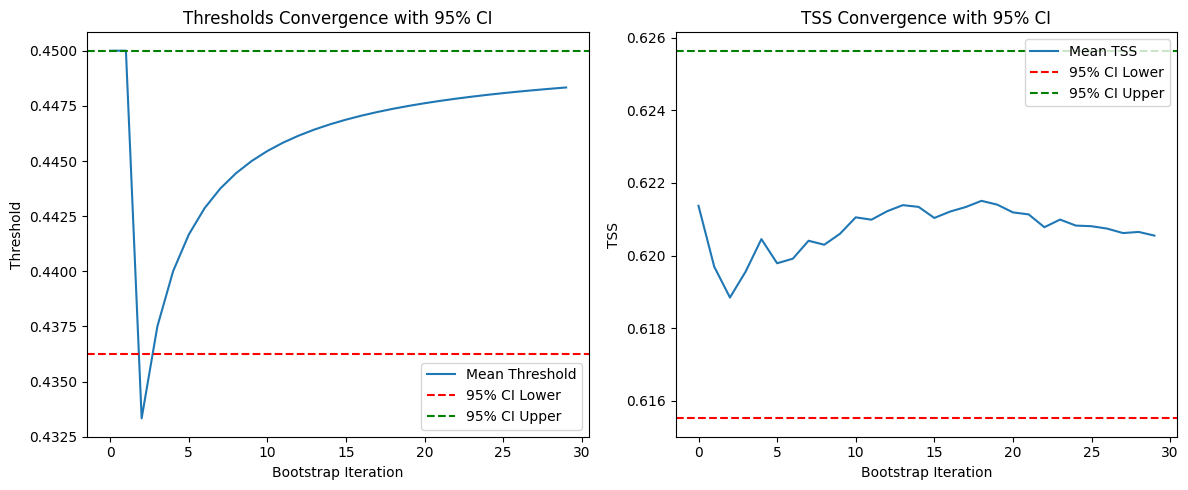

In [42]:
sci_def_24 = train_logistic(n_booststrap=30)
sci_def_24.train_logistic(sci_def_obj_24.inputs_profile, sci_def_obj_24.labels, "Mplus_train", pd.to_datetime('2010-05-01'), pd.to_datetime('2020-01-01'))

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.35000000000000003 - 0.4
The 95% CI for TSS is 0.6035501384505629 - 0.6202179387189997


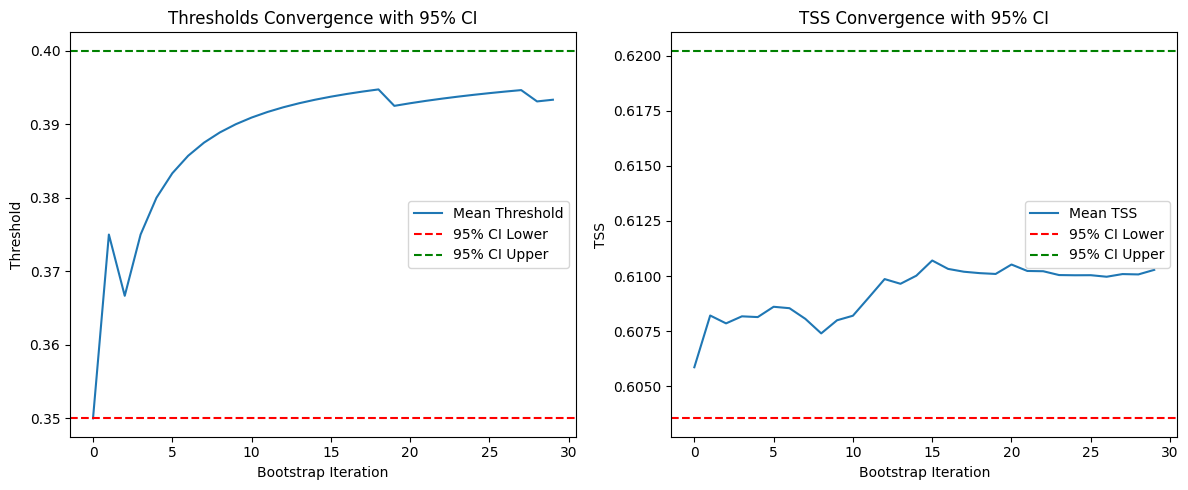

In [43]:
sci_def_12 = train_logistic(n_booststrap=30)
sci_def_12.train_logistic(sci_def_obj_12.inputs_profile, sci_def_obj_12.labels, "Mplus_train", pd.to_datetime('2010-05-01'), pd.to_datetime('2020-01-01'))

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.4 - 0.45
The 95% CI for TSS is 0.6157682880844646 - 0.6430976621417798


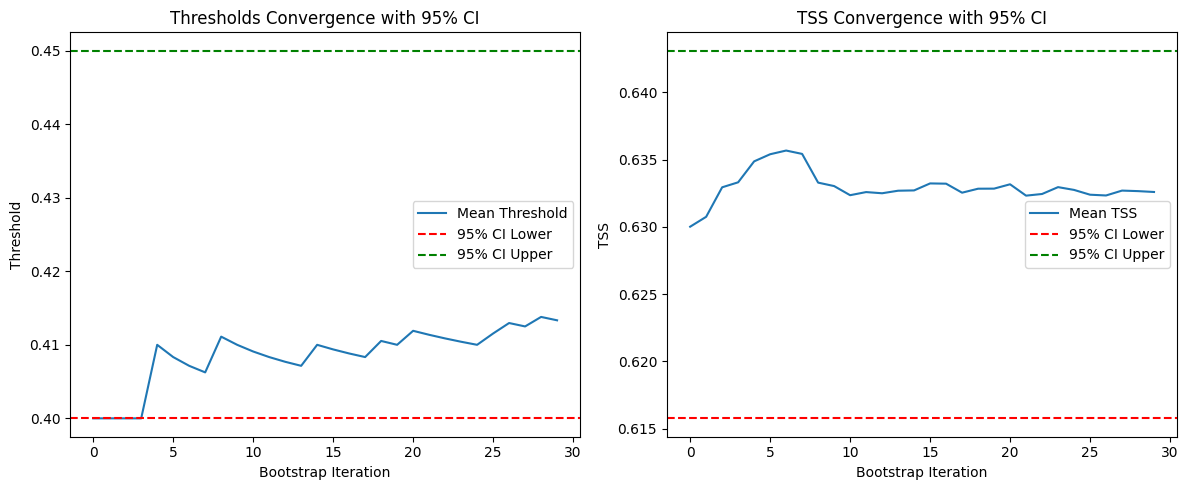

In [44]:
sci_def_6 = train_logistic(n_booststrap=30)
sci_def_6.train_logistic(sci_def_obj_6.inputs_profile, sci_def_obj_6.labels, "Mplus_train", pd.to_datetime('2010-05-01'), pd.to_datetime('2020-01-01'))

In [45]:
save_dir_sci_def = ".\\Logreg_models\\Sci_defSHARP"

In [46]:
for i, model in enumerate(sci_def_24.models):
    os.makedirs(save_dir_sci_def, exist_ok=True)
    model_path = os.path.join(save_dir_sci_def, f"logistic_sci_defSHARP_24_{i}.pth")
    joblib.dump(model, model_path)

In [47]:
for i, model in enumerate(sci_def_12.models):
    os.makedirs(save_dir_sci_def, exist_ok=True)
    model_path = os.path.join(save_dir_sci_def, f"logistic_sci_defSHARP_12_{i}.pth")
    joblib.dump(model, model_path)

In [48]:
for i, model in enumerate(sci_def_6.models):
    os.makedirs(save_dir_sci_def, exist_ok=True)
    model_path = os.path.join(save_dir_sci_def, f"logistic_sci_defSHARP_6_{i}.pth")
    joblib.dump(model, model_path)

In [9]:
opr_def_obj_24 = New_SampleConstruction()
opr_def_obj_24.samples_from_harp(opr, high_qual_sharp, lead_window=0, forecasting_window=24)

Processing HARPNUM: 1
Processing HARPNUM: 2
Processing HARPNUM: 5
Processing HARPNUM: 6
Processing HARPNUM: 8
Processing HARPNUM: 10
Processing HARPNUM: 11
Processing HARPNUM: 12
Processing HARPNUM: 14
Processing HARPNUM: 15
Processing HARPNUM: 16
Processing HARPNUM: 17
Processing HARPNUM: 19
Processing HARPNUM: 20
Processing HARPNUM: 23
Processing HARPNUM: 24
Processing HARPNUM: 25
Processing HARPNUM: 26
Processing HARPNUM: 29
Processing HARPNUM: 32
Processing HARPNUM: 35
Processing HARPNUM: 36
Processing HARPNUM: 37
Processing HARPNUM: 38
Processing HARPNUM: 39
Processing HARPNUM: 40
Processing HARPNUM: 41
Processing HARPNUM: 43
Processing HARPNUM: 44
Processing HARPNUM: 45
Processing HARPNUM: 46
Processing HARPNUM: 47
Processing HARPNUM: 49
Processing HARPNUM: 50
Processing HARPNUM: 51
Processing HARPNUM: 53
Processing HARPNUM: 54
Processing HARPNUM: 57
Processing HARPNUM: 58
Processing HARPNUM: 59
Processing HARPNUM: 62
Processing HARPNUM: 66
Processing HARPNUM: 67
Processing HARPN

D:\0626_temp\New_SampleConstruction.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oneharp['T_REC'] = pd.to_datetime(oneharp['T_REC'])


Processing HARPNUM: 10876
Processing HARPNUM: 10879
Processing HARPNUM: 10880
Processing HARPNUM: 10882
Processing HARPNUM: 10884
Processing HARPNUM: 10885
Processing HARPNUM: 10889
Processing HARPNUM: 10894
Processing HARPNUM: 10895
Processing HARPNUM: 10897
Processing HARPNUM: 10899
Processing HARPNUM: 10900
Processing HARPNUM: 10902
Processing HARPNUM: 10903
Processing HARPNUM: 10907
Processing HARPNUM: 10911
Processing HARPNUM: 10913
Processing HARPNUM: 10915
Processing HARPNUM: 10921
Processing HARPNUM: 10922
Processing HARPNUM: 10923
Processing HARPNUM: 10924
Processing HARPNUM: 10927
Processing HARPNUM: 10928
Processing HARPNUM: 10930
Processing HARPNUM: 10931
Processing HARPNUM: 10933
Processing HARPNUM: 10938
Processing HARPNUM: 10940
Processing HARPNUM: 10941
Processing HARPNUM: 10942
Processing HARPNUM: 10943
Processing HARPNUM: 10944
Processing HARPNUM: 10945
Processing HARPNUM: 10948
Processing HARPNUM: 10949
Processing HARPNUM: 10950
Processing HARPNUM: 10951
Processing H

In [10]:
opr_def_obj_12 = New_SampleConstruction()
opr_def_obj_12.samples_from_harp(opr, high_qual_sharp, lead_window=0, forecasting_window=12)

Processing HARPNUM: 1
Processing HARPNUM: 2
Processing HARPNUM: 5
Processing HARPNUM: 6
Processing HARPNUM: 8
Processing HARPNUM: 10
Processing HARPNUM: 11
Processing HARPNUM: 12
Processing HARPNUM: 14
Processing HARPNUM: 15
Processing HARPNUM: 16
Processing HARPNUM: 17
Processing HARPNUM: 19
Processing HARPNUM: 20
Processing HARPNUM: 23
Processing HARPNUM: 24
Processing HARPNUM: 25
Processing HARPNUM: 26
Processing HARPNUM: 29
Processing HARPNUM: 32
Processing HARPNUM: 35
Processing HARPNUM: 36
Processing HARPNUM: 37
Processing HARPNUM: 38
Processing HARPNUM: 39
Processing HARPNUM: 40
Processing HARPNUM: 41
Processing HARPNUM: 43
Processing HARPNUM: 44
Processing HARPNUM: 45
Processing HARPNUM: 46
Processing HARPNUM: 47
Processing HARPNUM: 49
Processing HARPNUM: 50
Processing HARPNUM: 51
Processing HARPNUM: 53
Processing HARPNUM: 54
Processing HARPNUM: 57
Processing HARPNUM: 58
Processing HARPNUM: 59
Processing HARPNUM: 62
Processing HARPNUM: 66
Processing HARPNUM: 67
Processing HARPN

D:\0626_temp\New_SampleConstruction.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oneharp['T_REC'] = pd.to_datetime(oneharp['T_REC'])


Processing HARPNUM: 10876
Processing HARPNUM: 10879
Processing HARPNUM: 10880
Processing HARPNUM: 10882
Processing HARPNUM: 10884
Processing HARPNUM: 10885
Processing HARPNUM: 10889
Processing HARPNUM: 10894
Processing HARPNUM: 10895
Processing HARPNUM: 10897
Processing HARPNUM: 10899
Processing HARPNUM: 10900
Processing HARPNUM: 10902
Processing HARPNUM: 10903
Processing HARPNUM: 10907
Processing HARPNUM: 10911
Processing HARPNUM: 10913
Processing HARPNUM: 10915
Processing HARPNUM: 10921
Processing HARPNUM: 10922
Processing HARPNUM: 10923
Processing HARPNUM: 10924
Processing HARPNUM: 10927
Processing HARPNUM: 10928
Processing HARPNUM: 10930
Processing HARPNUM: 10931
Processing HARPNUM: 10933
Processing HARPNUM: 10938
Processing HARPNUM: 10940
Processing HARPNUM: 10941
Processing HARPNUM: 10942
Processing HARPNUM: 10943
Processing HARPNUM: 10944
Processing HARPNUM: 10945
Processing HARPNUM: 10948
Processing HARPNUM: 10949
Processing HARPNUM: 10950
Processing HARPNUM: 10951
Processing H

In [11]:
opr_def_obj_6 = New_SampleConstruction()
opr_def_obj_6.samples_from_harp(opr, high_qual_sharp, lead_window=0, forecasting_window=6)

Processing HARPNUM: 1
Processing HARPNUM: 2
Processing HARPNUM: 5
Processing HARPNUM: 6
Processing HARPNUM: 8
Processing HARPNUM: 10
Processing HARPNUM: 11
Processing HARPNUM: 12
Processing HARPNUM: 14
Processing HARPNUM: 15
Processing HARPNUM: 16
Processing HARPNUM: 17
Processing HARPNUM: 19
Processing HARPNUM: 20
Processing HARPNUM: 23
Processing HARPNUM: 24
Processing HARPNUM: 25
Processing HARPNUM: 26
Processing HARPNUM: 29
Processing HARPNUM: 32
Processing HARPNUM: 35
Processing HARPNUM: 36
Processing HARPNUM: 37
Processing HARPNUM: 38
Processing HARPNUM: 39
Processing HARPNUM: 40
Processing HARPNUM: 41
Processing HARPNUM: 43
Processing HARPNUM: 44
Processing HARPNUM: 45
Processing HARPNUM: 46
Processing HARPNUM: 47
Processing HARPNUM: 49
Processing HARPNUM: 50
Processing HARPNUM: 51
Processing HARPNUM: 53
Processing HARPNUM: 54
Processing HARPNUM: 57
Processing HARPNUM: 58
Processing HARPNUM: 59
Processing HARPNUM: 62
Processing HARPNUM: 66
Processing HARPNUM: 67
Processing HARPN

D:\0626_temp\New_SampleConstruction.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oneharp['T_REC'] = pd.to_datetime(oneharp['T_REC'])


Processing HARPNUM: 10876
Processing HARPNUM: 10879
Processing HARPNUM: 10880
Processing HARPNUM: 10882
Processing HARPNUM: 10884
Processing HARPNUM: 10885
Processing HARPNUM: 10889
Processing HARPNUM: 10894
Processing HARPNUM: 10895
Processing HARPNUM: 10897
Processing HARPNUM: 10899
Processing HARPNUM: 10900
Processing HARPNUM: 10902
Processing HARPNUM: 10903
Processing HARPNUM: 10907
Processing HARPNUM: 10911
Processing HARPNUM: 10913
Processing HARPNUM: 10915
Processing HARPNUM: 10921
Processing HARPNUM: 10922
Processing HARPNUM: 10923
Processing HARPNUM: 10924
Processing HARPNUM: 10927
Processing HARPNUM: 10928
Processing HARPNUM: 10930
Processing HARPNUM: 10931
Processing HARPNUM: 10933
Processing HARPNUM: 10938
Processing HARPNUM: 10940
Processing HARPNUM: 10941
Processing HARPNUM: 10942
Processing HARPNUM: 10943
Processing HARPNUM: 10944
Processing HARPNUM: 10945
Processing HARPNUM: 10948
Processing HARPNUM: 10949
Processing HARPNUM: 10950
Processing HARPNUM: 10951
Processing H

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.4 - 0.5
The 95% CI for TSS is 0.6087921797841858 - 0.6172848716698165


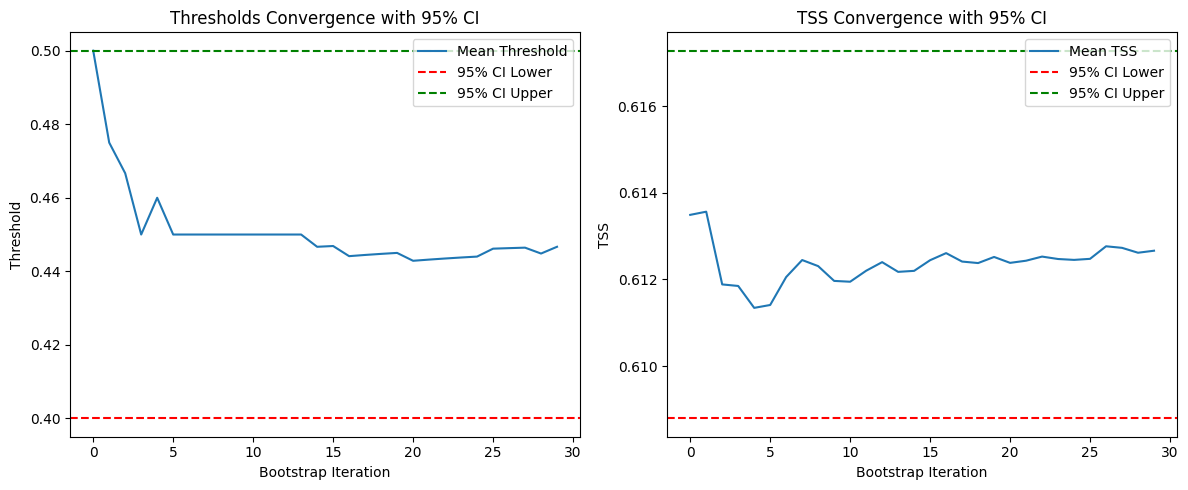

In [12]:
opr_def_24 = train_logistic(n_booststrap=30)
opr_def_24.train_logistic(opr_def_obj_24.inputs_profile, opr_def_obj_24.labels, "Mplus_train", pd.to_datetime('2010-05-01'), pd.to_datetime('2020-01-01'))

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.35000000000000003 - 0.4274999999999999
The 95% CI for TSS is 0.6134042100605813 - 0.6420599346538697


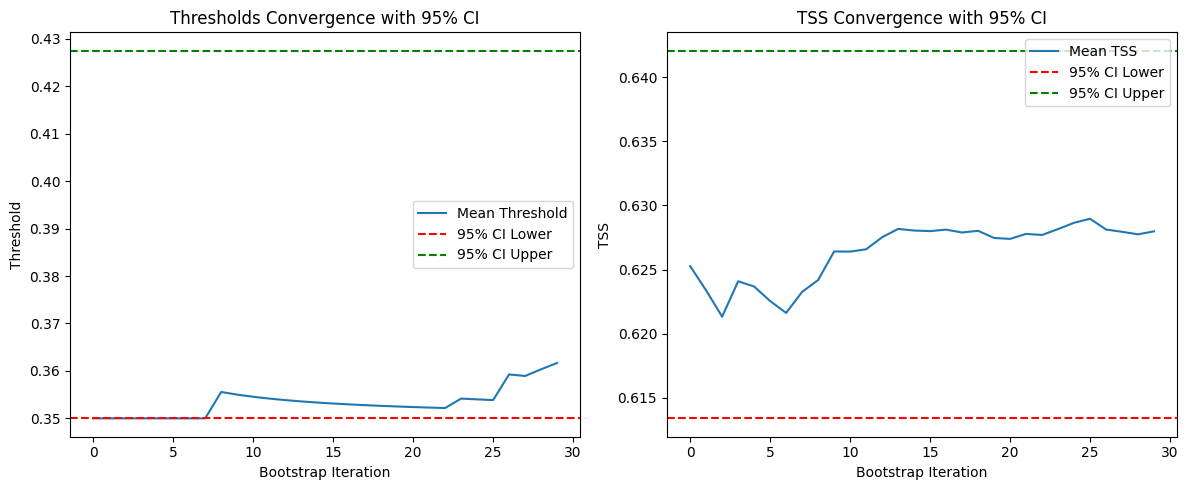

In [13]:
opr_def_12 = train_logistic(n_booststrap=30)
opr_def_12.train_logistic(opr_def_obj_12.inputs_profile, opr_def_obj_12.labels, "Mplus_train", pd.to_datetime('2010-05-01'), pd.to_datetime('2020-01-01'))

Bootstrap iteration 1/30
Bootstrap iteration 2/30
Bootstrap iteration 3/30
Bootstrap iteration 4/30
Bootstrap iteration 5/30
Bootstrap iteration 6/30
Bootstrap iteration 7/30
Bootstrap iteration 8/30
Bootstrap iteration 9/30
Bootstrap iteration 10/30
Bootstrap iteration 11/30
Bootstrap iteration 12/30
Bootstrap iteration 13/30
Bootstrap iteration 14/30
Bootstrap iteration 15/30
Bootstrap iteration 16/30
Bootstrap iteration 17/30
Bootstrap iteration 18/30
Bootstrap iteration 19/30
Bootstrap iteration 20/30
Bootstrap iteration 21/30
Bootstrap iteration 22/30
Bootstrap iteration 23/30
Bootstrap iteration 24/30
Bootstrap iteration 25/30
Bootstrap iteration 26/30
Bootstrap iteration 27/30
Bootstrap iteration 28/30
Bootstrap iteration 29/30
Bootstrap iteration 30/30
The 95% CI for threshold is 0.35000000000000003 - 0.45
The 95% CI for TSS is 0.5462644670927622 - 0.5755955259975817


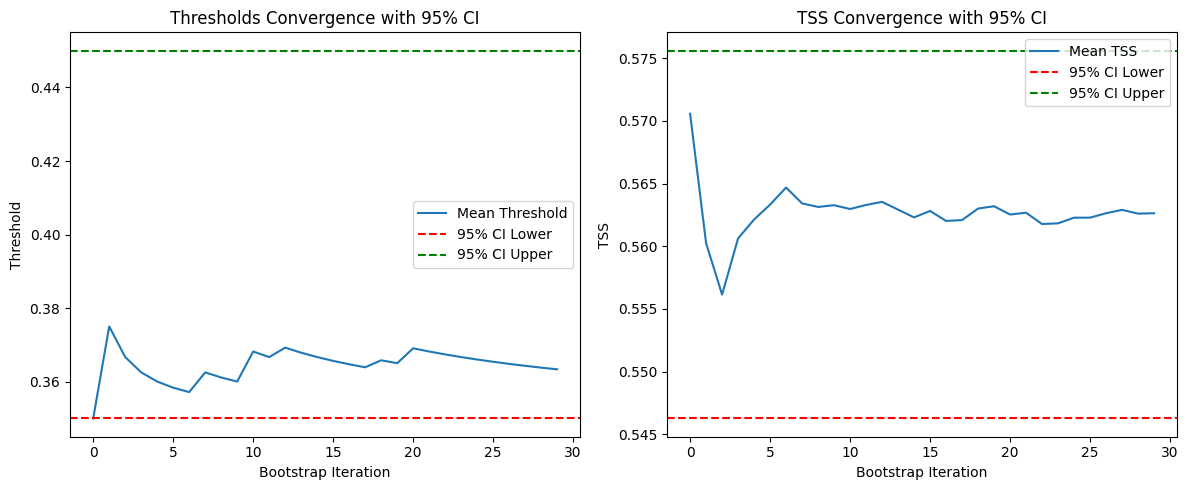

In [14]:
opr_def_6 = train_logistic(n_booststrap=30)
opr_def_6.train_logistic(opr_def_obj_6.inputs_profile, opr_def_obj_6.labels, "Mplus_train", pd.to_datetime('2010-05-01'), pd.to_datetime('2020-01-01'))

In [15]:
save_dir_opr_def = ".\\Logreg_models\\Opr_defSHARP"

In [16]:
for i, model in enumerate(opr_def_24.models):
    os.makedirs(save_dir_opr_def, exist_ok=True)
    model_path = os.path.join(save_dir_opr_def, f"logistic_opr_defSHARP_24_{i}.pth")
    joblib.dump(model, model_path)

In [17]:
for i, model in enumerate(opr_def_12.models):
    os.makedirs(save_dir_opr_def, exist_ok=True)
    model_path = os.path.join(save_dir_opr_def, f"logistic_opr_defSHARP_12_{i}.pth")
    joblib.dump(model, model_path)

In [18]:
for i, model in enumerate(opr_def_6.models):
    os.makedirs(save_dir_opr_def, exist_ok=True)
    model_path = os.path.join(save_dir_opr_def, f"logistic_opr_defSHARP_6_{i}.pth")
    joblib.dump(model, model_path)